<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Data Preparation and Model Training

In [1]:
import os
from google.colab import drive
from google.colab import files

#for image processing
!pip install pillow
import random
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt

#for metadata
import pandas as pd

#for data file structure
!pip install pip install split-folders
import splitfolders
import shutil

#for modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchsummary import summary

#for metrics
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Step 1: Link Notebook to GitHub and Google Drive

In [3]:
# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "BrainAgingComputerVision" # Enter repo name
git_path = 'https://github.com/MRWilliamsGit/BrainAgingComputerVision.git'
!git clone "{git_path}"

#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Connect to Google Drive
drive.mount('/content/gdrive')
#%cd gdrive/MyDrive/School

Cloning into 'BrainAgingComputerVision'...
remote: Enumerating objects: 110, done.
remote: Total 110 (delta 0), reused 0 (delta 0), pack-reused 110
Receiving objects: 100% (110/110), 60.50 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Mounted at /content/gdrive


## Step 2: Data Prep

In [4]:
#pull up image metadata
filein = '/content/gdrive/My Drive/School/cn_age_df.csv'
data = pd.read_csv(filein)
#data.head()


In [ ]:
#to reset:
shutil.rmtree("/content/image_data")

In [5]:
#import files (1268 files)
#note that naming convention includes "test" and "val" but that is not for this project
!unzip '/content/gdrive/My Drive/School/image_data.zip' > /dev/null

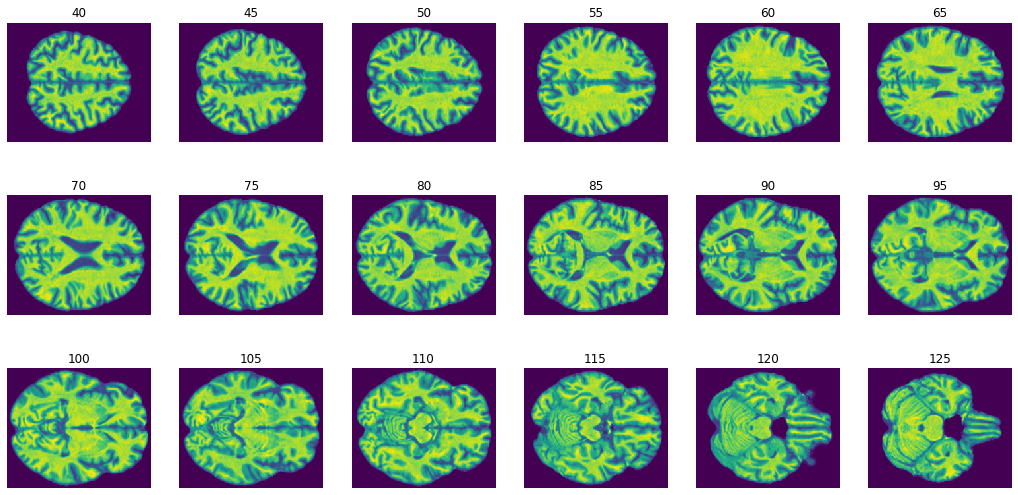

In [ ]:
#pick an image to take a look at
image_path = '/content/image_data/0_A_train.npy'
image3D = np.load(image_path)

#show image size (218*182*182)
#print(image3D.size)

#loop to show slices, start at slice 10
plt.rcParams['figure.figsize'] = [18, 9]
fig, axs = plt.subplots(3, 6)
i = 40
for m in range(3):
  for w in range(6):
    im = Image.fromarray((image3D[i] * 255).astype(np.uint8))
    axs[m, w].imshow(im, interpolation='nearest')
    axs[m, w].set_title(str(i))
    axs[m, w].axis('off')
    i += 5

fig.savefig("slices2.png")

### A) For Classification Model: convert, sort, batch and load files

In [ ]:
#to reset:
shutil.rmtree("/content/data")

In [ ]:
#establish the file structure required for the dataloaders
folders = ['50','60','70','80','90']
os.mkdir("/content/data/")

for i in folders:
  base = '/content/data'
  path = os.path.join(base, i,)
  os.mkdir(path)

In [ ]:
#pull out image slice, convert to jpeg, then move to class (age) folder
#note: conversion to jpeg lets us use the datasets.Imageloader
#note: images will be converted to tensors during transform since loaders can't process images

#this is the slice picked from the 3D image
imslice = 85

for i in range(len(data)):

  #first load the image, pull out a slice and convert it to jpeg
  imgpl1 = "/content/image_data/" + data.loc[i][0] + '.npy'
  imgjpl = "/content/image_data/" + data.loc[i][0] + '.jpg'
  image3D = np.load(imgpl1)
  im = Image.fromarray((image3D[imslice] * 255).astype(np.uint8))
  im.save(imgjpl)

  #then loop through to determine which folder it belongs to
  for f in folders:
    if data.loc[i][5] < int(f):
      #if less than the folder name, move to the folder before f
      imgpl2 = "/content/data/" + str(int(f)-10) + "/" + data.loc[i][0] + '.jpg'
      os.rename(imgjpl, imgpl2)
      break
    elif data.loc[i][5] >= 90:
      imgpl2 = "/content/data/90/" + data.loc[i][0] + '.jpg'
      os.rename(imgjpl, imgpl2)
      break

In [ ]:
#show how many in each class
for f in folders:
  place = "/content/data/" + str(f)
  print("Decade: " + str(f) + ", Count: " + str(len(os.listdir(place))))

#since there are only 7 in the 50-60 decade, discard that folder and update folders list
#shutil.rmtree("/content/data/50")
#folders = ['60','70','80','90']


Decade: 50, Count: 7
Decade: 60, Count: 167
Decade: 70, Count: 667
Decade: 80, Count: 393
Decade: 90, Count: 33


In [ ]:
#training/test split
#ratio: 90/10
splitfolders.ratio('/content/data', output='/content/data', ratio=(.9, 0.1))  

Copying files: 1267 files [00:00, 2151.05 files/s]


In [ ]:
#get datasets
Tdataset = datasets.ImageFolder('/content/data/train/')
Vdataset = datasets.ImageFolder('/content/data/val/')

#define transformation - same for both train and val
data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.Grayscale(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5],std=[0.5])])

#get datasets with transformation
Tdataset = datasets.ImageFolder('/content/data/train/', transform=data_transform)
Vdataset = datasets.ImageFolder('/content/data/val/', transform=data_transform)

#add to loaders (batch size of 36 would be square root of dataset)
batch_size = 30
Train_loader = torch.utils.data.DataLoader(Tdataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
Val_loader = torch.utils.data.DataLoader(Vdataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)


In [ ]:
#set up class names for visualizations and checking
idx_to_class = {i:j for i,j in enumerate(folders)}
class_to_idx = {v:k for k,v in idx_to_class.items()}

torch.Size([30, 1, 224, 224])


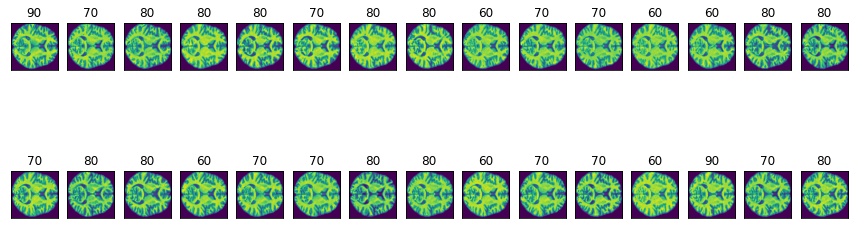

In [ ]:
# Visualize a batch of images (note they were compressed sideways)
images, labels = iter(Train_loader).next()
print(images.shape)
images = images.numpy() # Convert images to numpy for display
labels = labels.numpy()

# plot the images in the batch, along with the corresponding labels
# note that images are greyscale, it's just the plot aesthetic that makes them colorful
fig = plt.figure(figsize=(15, 5))
for idx in range(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]))
    ax.set_title(idx_to_class[labels[idx]])

### B) For Regression Model: sort files, manipulate in custom class, load in dataloaders

In [6]:
#divide files into training and test sets, ratio: 90/10
#note this does not ensure that classes are equivalently represented
flist = os.listdir('/content/image_data/')
random.shuffle(flist)
tlen = round(len(flist)*.9)
tlist = flist[0:tlen]
vlist = flist[tlen:len(flist)]
os.mkdir('/content/image_data/train/')
os.mkdir('/content/image_data/val/')

for f in tlist:
  imgpl1 = "/content/image_data/" + f
  imgpl2 = "/content/image_data/train/" + f
  os.rename(imgpl1, imgpl2)
for f in vlist:
  imgpl1 = "/content/image_data/" + f
  imgpl2 = "/content/image_data/val/" + f
  os.rename(imgpl1, imgpl2)

In [7]:
#define class for the images
class BrainBits(Dataset):

  #receives the folder of images, the csv file of data, and the transform
  def __init__(self, img_path, label_file, transform):
    self.root = img_path
    self.data_paths = [f for f in sorted(os.listdir(img_path))]
    self.dataf = label_file
    self.transform = transform

  def __getitem__(self, idx):

    #get file then set 85 slice as image
    imgpath = self.root + self.data_paths[idx]
    image3D = np.load(imgpath)
    img = Image.fromarray((image3D[85] * 255).astype(np.uint8))

    #get name of file
    imgn = self.data_paths[idx].split(".")
    imgn = imgn[0]

    #find filename in dataf, set age as label
    line = self.dataf.loc[self.dataf['Data ID'] == imgn]
    label = line.iloc[0][5]

    #apply transform
    if self.transform:
      img = self.transform(img)
    return img, label

  def __len__(self):
    return len(self.data_paths)

In [8]:
#define transformation - same for both train and val
data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.Grayscale(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5],std=[0.5])])

In [9]:
#get data
train_data = BrainBits(img_path='/content/image_data/train/', label_file=data, transform=data_transform)
test_data = BrainBits(img_path='/content/image_data/val/', label_file=data, transform=data_transform)

#make loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

# Store size of training set
dataset_size = len(train_data)


torch.Size([32, 1, 224, 224])


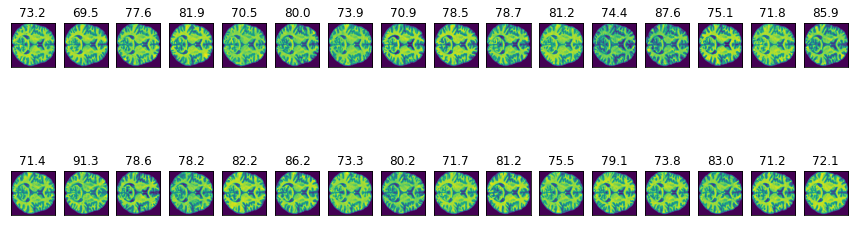

In [10]:
# Visualize a batch of images 
# note: they were compressed sideways, and yes, ages were recorded to a decimal
images, labels = iter(train_loader).next()
print(images.shape)

# plot the images in the batch, along with the corresponding labels
# note that images are greyscale, it's just the plot aesthetic that makes them colorful
fig = plt.figure(figsize=(15, 5))
for idx in range(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]))
    ax.set_title(labels[idx].tolist())

## Step 3: Define and Train Model

### A) Classification Version

In [ ]:
# Load a resnet18 pre-trained model
model_resnet = torchvision.models.resnet18(pretrained=True)

# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in model_resnet.parameters():
    param.requires_grad = False
    
# Replace the resnet input layer to take in grayscale images (1 input channel), since it was originally trained on color (3 input channels)
in_channels = 1
model_resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the resnet final layer with a new fully connected Linear layer we will train on our task
# Number of out units is number of classes (5)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 5)

# Display a summary of the layers of the model and output shape after each layer
#summary(model_resnet,(images.shape[1:]),batch_size=batch_size,device="cpu")

In [ ]:
#train function
def train_model(model,criterion,optimizer,loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        running_corrects = 0
        
        for i, data in enumerate(loader):
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item() * inputs.size(0)
            # Track number of correct predictions
            running_corrects += torch.sum(preds == labels.data)
            
        # Calculate and display average loss and accuracy for the epoch
        epoch_loss = running_loss / len(Tdataset)
        epoch_acc = running_corrects.double() / len(Tdataset)
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        loss_over_time.append(epoch_loss)

    return loss_over_time

Loss: 1.2948 Acc: 0.4921
Loss: 1.1095 Acc: 0.5387
Loss: 1.0854 Acc: 0.5536
Loss: 1.0659 Acc: 0.5598
Loss: 1.0474 Acc: 0.5712
Loss: 1.0307 Acc: 0.5782
Loss: 1.0217 Acc: 0.5852
Loss: 1.0091 Acc: 0.5817
Loss: 0.9949 Acc: 0.6072
Loss: 0.9837 Acc: 0.6028
Loss: 0.9811 Acc: 0.6230
Loss: 0.9675 Acc: 0.6178
Loss: 0.9667 Acc: 0.6125
Loss: 0.9567 Acc: 0.6169
Loss: 0.9496 Acc: 0.6204
Loss: 0.9416 Acc: 0.6353
Loss: 0.9307 Acc: 0.6353
Loss: 0.9304 Acc: 0.6344
Loss: 0.9244 Acc: 0.6344
Loss: 0.9143 Acc: 0.6547


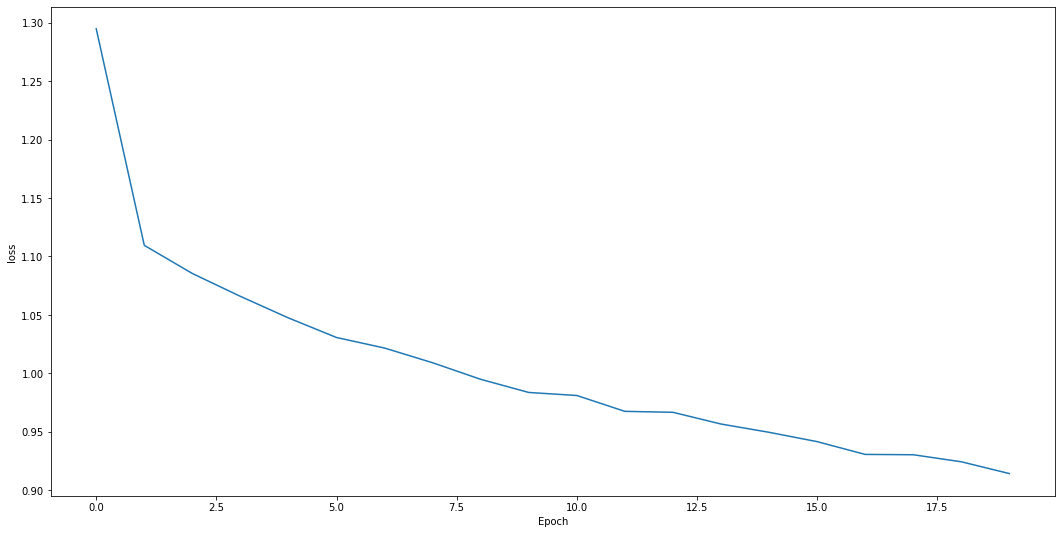

In [ ]:
# Train the model
n_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cost_path = train_model(model_resnet,criterion,optimizer,Train_loader,n_epochs,device)

# Visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

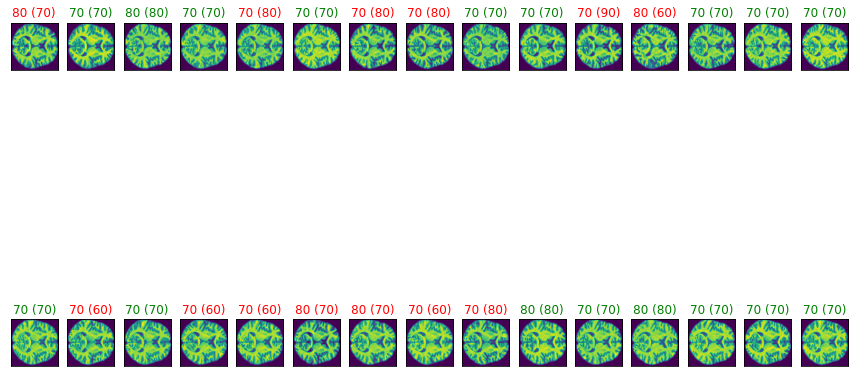

In [ ]:
# Display a batch of predictions

def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = iter(dataloader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        labels = labels.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.permute(1,2,0).cpu().numpy() # Permute axes because im.show() expects dims [W,H,C] and PyTorch/NumPy use [C,W,H]
        mean = np.array([0.5])
        std = np.array([0.5])
        image = tf.convert_to_tensor(std) * image + tf.convert_to_tensor(mean)
        image = np.clip(image, 0, 1)
        ax.imshow(np.squeeze(image))
        ax.set_title("{} ({})".format(idx_to_class[preds[idx]], idx_to_class[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(model_resnet,Val_loader,device)

### B) Regression Version

In [67]:
#train function
def train_model2(model,criterion,optimizer,loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        running_corrects = 0
        
        for i, data in enumerate(loader):
            
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)
            labels.resize_(len(labels), 1)

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model.forward(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels.float())

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Collect loss
            running_loss += loss.item()
            
        # Calculate and display average loss for the epoch
        epoch_loss = running_loss / len(loader)
        print('Loss: {:4f}'.format(epoch_loss))

        loss_over_time.append(epoch_loss)

    return loss_over_time

In [20]:
# Load a resnet18 pre-trained model
regmodel = torchvision.models.resnet18(pretrained=True)

# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in regmodel.parameters():
    param.requires_grad = False
    
# Replace the resnet input layer to take in grayscale images (1 input channel), since it was originally trained on color (3 input channels)
in_channels = 1
regmodel.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the resnet final layer with a new fully connected Linear layer we will train on our task
# Number of out units is 1 because regression
num_ftrs = regmodel.fc.in_features
regmodel.fc = nn.Linear(num_ftrs, 1)


In [68]:
# Train the model
n_epochs = 20
criterion = nn.MSELoss()
optimizer = optim.SGD(regmodel.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cost_path = train_model2(regmodel,criterion,optimizer,train_loader,n_epochs,device)

# Visualize the loss as the network trains
plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

KeyboardInterrupt: ignored

In [91]:
# Function to get predictions
def get_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = iter(dataloader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        preds = model(images)
        preds = np.squeeze(preds.cpu().numpy())
        preds = np.around(preds, decimals=1)
        labels = labels.cpu().numpy()
    
    return preds, labels

# Function to display a batch of predictions
def visualize_results(preds, labels):

    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        #images
        ax = fig.add_subplot(4, len(preds)//4, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.permute(1,2,0).cpu().numpy() # Permute axes because im.show() expects dims [W,H,C] and PyTorch/NumPy use [C,W,H]
        mean = np.array([0.5])
        std = np.array([0.5])
        image = tf.convert_to_tensor(std) * image + tf.convert_to_tensor(mean)
        image = np.clip(image, 0, 1)
        ax.imshow(np.squeeze(image))
        #titles
        line = str(preds[idx])+" ("+str(labels[idx])+")"
        ax.set_title(line, color=("green" if abs(preds[idx]-labels[idx])<=4 else "red"))
    return

Test set MSE: 58.9537432289168


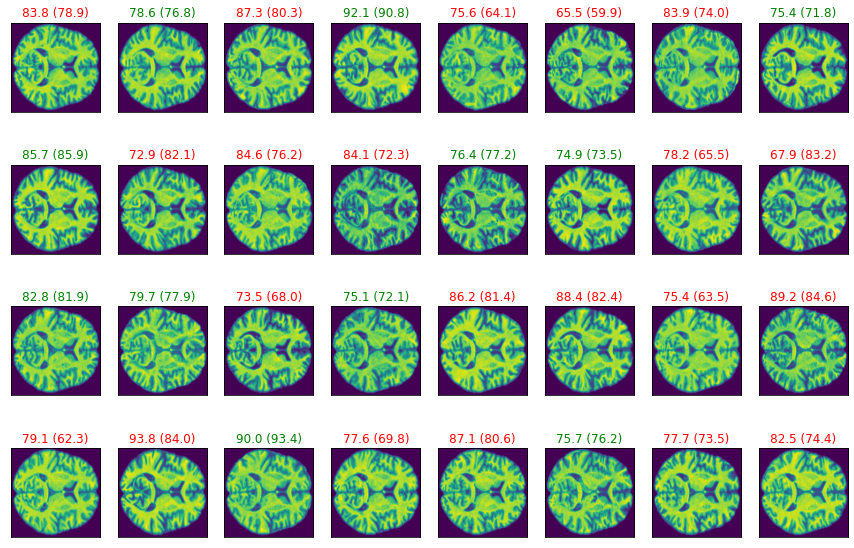

In [102]:
#test and display results
preds, labels = get_results(regmodel,test_loader,device)
print('Test set MSE: '+ str(mean_squared_error(labels,preds)))

visualize_results(preds, labels)

## Step 4: Save Model

### A) save dictionary

In [ ]:
# OPTION 1: Save the state dictionary of the model
model_dir = 'models/'
os.makedirs(os.path.dirname(model_dir), exist_ok=True)
filename = 'model_state_dict.pt'

# Save the model's learned parameters (state_dict)
torch.save(model_resnet.state_dict(), model_dir+filename)

# Initialize new model and load state dict previously saved into it
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)
in_channels = 1
model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

model = model.to(device)
model.load_state_dict(torch.load(model_dir+filename, map_location=device))

# Print model's state_dict
#print("Model's state_dict:")
#for param_tensor in model.state_dict():
    #print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
# Test loaded model
#acc = test_model(model,testloader,device)
#print()
#print('Test set accuracy is {:.3f}'.format(acc))

Model's state_dict:
conv1.weight 	 torch.Size([64, 1, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight 	 torch.Size([64])
layer1.1.bn1.bias 	 torch.Size([64])
layer1.1.bn1.running_mean 	 torch.Size([64])
layer1.1.bn1.running_var 	 torch.Size([64])
layer1.1.bn1.num_batc

### B) save model

In [61]:
# Save the entire model
torch.save(regmodel, "/content/model.pt")

# Load model
#model2 = torch.load("/content/model.pt")

# Test loaded model
#acc = test_model(model2,testloader,device)
#print('Test set accuracy is {:.3f}'.format(acc))

### download

In [ ]:
#download
files.download('/content/model.pt')
#files.download('/content/models/model_state_dict.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>